In [1]:
import operator
import random
import requests
import time
import csv
import os
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
from scipy import stats
from ast import literal_eval
from matplotlib import pyplot as plt
from statsmodels.stats import diagnostic
from datetime import datetime
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#colors used when comparing genders
PURPLE = 'purple'
ORANGE = '#ffb82c'

#colors used when generic comparisons
BLUE = '#0173b2'
RED = '#d55e00'

#print(sns.color_palette("colorblind").as_hex())
#sns.color_palette("colorblind")

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# 1. Load the data
<a class="anchor" id="load"></a>

In [3]:
DATA_PATH = './data'
MOVIE_PATH = os.path.join(DATA_PATH, 'movie.metadata.tsv')
CHAR_PATH = os.path.join(DATA_PATH, 'character.metadata.tsv')
THE_NUMBERS_PATH = os.path.join(DATA_PATH, 'actors_xxxx_the_numbers')

In [4]:
#CONSTANTS
YEAR_OFFSET=2 # if 3: last triplet 2019, 2020, 2021;; if 2: last triplet 2020, 2021, 2022
START_INDEX=28 # 20 correspond to the triplet 2000, 2001, 2002
START_YEAR=1980+START_INDEX

In [5]:
#read the tsv files having the actor's popularity
tab_years=np.arange(1980,2022+1)
actors_rating=[]
for i, year in enumerate (tab_years):
    path_numbers = os.path.join(THE_NUMBERS_PATH, 'actors_{}_the_numbers.tsv'.format(year))
    actors_rating.append(pd.read_csv(path_numbers,
                              sep='\t',
                              escapechar=',',
                              names=['actor_name','popularity', 'movies', 'avg_billing']))

# 2. Creation of a pipeline

#### Check for duplicated actor name for each year

In [6]:
#check for duplicated actor name for each year
total_duplicated=0
for i in range (len(tab_years)):
    total_duplicated+=actors_rating[i].duplicated(subset='actor_name').sum()
print('There are {} actors that appear twice in the same year.'.format(total_duplicated))

There are 0 actors that appear twice in the same year.


#### Formatting the dataset in a useful way

In [7]:
number_actors_per_year=[]
df_ratings_all_years=actors_rating[0].set_index('actor_name')[['popularity']]
df_ratings_all_years.set_axis([*df_ratings_all_years.columns[:-1], int('{}'.format(1980))], axis=1, inplace=True)
for i in range (len(tab_years)-1):
    number_actors_per_year.append((len(actors_rating[i+1])))
    df_ratings_all_years=pd.concat([df_ratings_all_years, actors_rating[i+1].set_index('actor_name')[['popularity']]],  axis=1)
    df_ratings_all_years.set_axis([*df_ratings_all_years.columns[:-1], int('{}'.format(i+1+1980))], axis=1, inplace=True)
df_ratings_all_yearsT=df_ratings_all_years.T

ACTORS=list(df_ratings_all_yearsT)#all the actors present in the numbers dataset

print('There is a total of {} actors in the Number dataset.'.format(len(ACTORS)))

There is a total of 2702 actors in the Number dataset.


#### Mean of the score per actor

In [8]:
df_ratings_all_years['mean_score'] = df_ratings_all_years.mean(axis=1)
print("Actors with the highest mean popularity score computed on the 42 years of the dataset.")
#pd.set_option('display.max_columns', None)
df_ratings_all_years.fillna(0, inplace=True)

Actors with the highest mean popularity score computed on the 42 years of the dataset.


In [9]:
#Find the yearly score of each actor but the score from the numbers is over the last three years.
#The combined score of year n = yearly score year n + yearly score year n-1 + yearly score year n-2
#That's why the score of year 1979 and 1978 are computed and added to the dataframe.
def find_score_7879(row, yeartocheck):
    reel_moinsa=0
    reel_moinsb=0
    firstzerofound=0 
    cum78=0
    cum79=0
    for i, year in enumerate(tab_years):
        if firstzerofound == 1:
            break
        if row[year] == 0:
            firstzerofound=1
            for j in range(1, year-1979):
                reel_moinsc=row[year-j]-reel_moinsa-reel_moinsb
                reel_moinsa=reel_moinsb
                
                cum78=reel_moinsc
                cum79=cum78+reel_moinsb
                
                reel_moinsb=reel_moinsc

    if(yeartocheck==1978):
        return cum78
    elif(yeartocheck==1979):
        return cum79
    else:
        print("error, wrong date")
        return-1

In [10]:
df_ratings_all_years[1978]=df_ratings_all_years.apply(lambda row: find_score_7879(row, 1978), axis=1)
df_ratings_all_years[1979]=df_ratings_all_years.apply(lambda row: find_score_7879(row, 1979), axis=1)
first_column = df_ratings_all_years.pop(1979)
df_ratings_all_years.insert(0, 1979, first_column)
first_column = df_ratings_all_years.pop(1978)
df_ratings_all_years.insert(0, 1978, first_column)
df_ratings_all_years.head()

,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,mean_score
actor_name,,,,,,,,,,,,,,,,,,,,,
Jane Fonda,175.0,341.0,440.0,364.0,198.0,99.0,0.0,0.0,63.0,63.0,...,16.0,16.0,16.0,0.0,59.0,59.0,59.0,0.0,0.0,109.312500
Clint Eastwood,97.0,186.0,360.0,263.0,260.0,180.0,347.0,343.0,332.0,165.0,...,16.0,0.0,0.0,0.0,71.0,71.0,71.0,36.0,36.0,132.052632
John Belushi,99.0,177.0,269.0,295.0,217.0,125.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226.500000
Burt Reynolds,178.0,262.0,262.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,114.500000
Goldie Hawn,88.0,88.0,258.0,170.0,251.0,81.0,147.0,66.0,132.0,125.0,...,0.0,0.0,0.0,43.0,43.0,43.0,0.0,0.0,0.0,104.814815


In [11]:
df_e_metric=df_ratings_all_years.copy()

In [12]:
#find the yearly score of each actor
def find_yearly_score(row):
    yearly_score=[]
    for i, year in enumerate(tab_years):
        if (year==1980):
            yearly_score.append(row[1978]) #1978
            yearly_score.append(row[1979]-yearly_score[i]) #1979
        yearly_score.append(row[year]-yearly_score[i+1]-yearly_score[i]) #le reste
    return yearly_score

In [13]:
supp_tab_years=tab_years.tolist()
tab_years_descending=tab_years.tolist()
tab_years_descending.reverse()
supp_tab_years.insert(0, 1979)
supp_tab_years.insert(0, 1978)

df_e_metric=df_e_metric.apply(lambda row: find_yearly_score(row), axis=1).to_frame()

#change over the df to have it in a normalized way.
df_reel_years=pd.DataFrame(df_e_metric[0].to_list(), columns=supp_tab_years)
df_reel_years['actor_name'] = df_ratings_all_years.index.values
df_reel_years.set_index('actor_name', inplace=True)
df_reel_years=df_reel_years.drop([1978, 1979], axis=1)

#save the yearly score in a tsv.
OUTPUT_FILE_NUMBERS = 'the_numbers_cleaned_yearly.tsv'
OUTPUT_PATH = os.path.join(DATA_PATH, OUTPUT_FILE_NUMBERS)
df_reel_years.to_csv(OUTPUT_PATH, sep="\t")
df_reel_years.head()

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
actor_name,,,,,,,,,,,,,,,,,,,,,
Jane Fonda,99.0,99.0,0.0,0.0,0.0,0.0,63.0,0.0,0.0,0.0,...,0.0,16.0,0.0,0.0,0.0,59.0,0.0,0.0,0.0,0.0
Clint Eastwood,174.0,0.0,86.0,94.0,167.0,82.0,83.0,0.0,72.0,28.0,...,0.0,0.0,0.0,0.0,0.0,71.0,0.0,0.0,36.0,0.0
John Belushi,92.0,125.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Burt Reynolds,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Goldie Hawn,170.0,0.0,81.0,0.0,66.0,0.0,66.0,59.0,0.0,0.0,...,0.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0


In [14]:
#create the inverse exp function
def inverse_exp(x):
    return 1/np.exp(0.1*x-1.2)

Text(0, 0.5, 'Weight')

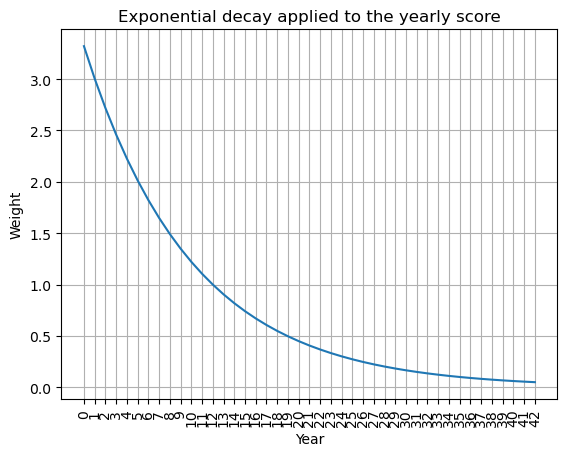

In [15]:
years_from_0=np.arange(0, 2022-1979)
exponential_decay=inverse_exp(years_from_0)
plt.plot(years_from_0, exponential_decay)
plt.grid()
plt.xticks(years_from_0)
plt.xticks(rotation=90)
plt.title('Exponential decay applied to the yearly score')
plt.xlabel('Year')
plt.ylabel('Weight')

In [16]:
def compute_weight(row):
    one_year=0
    one_actor=[]
    for i, year_out in enumerate(tab_years_descending):
        one_year=0
        for j, year_in in enumerate(tab_years_descending[i:]):
            one_year=one_year+row[year_in]*exponential_decay[j]
            
        one_actor.insert(0, one_year)
    return one_actor

In [17]:
df_yearly_decayed=df_reel_years.apply(lambda row: compute_weight(row), axis=1).to_frame()

df_yearly_decayed=pd.DataFrame(df_yearly_decayed[0].to_list(), columns=tab_years)
df_yearly_decayed['actor_name'] = df_ratings_all_years.index.values
df_yearly_decayed.set_index('actor_name', inplace=True)

#save the file in a tsv
OUTPUT_FILE_NUMBERS = 'the_numbers_cleaned_yearly_decayed.tsv'
OUTPUT_PATH = os.path.join(DATA_PATH, OUTPUT_FILE_NUMBERS)
df_yearly_decayed.to_csv(OUTPUT_PATH, sep="\t")
df_yearly_decayed.head()

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
actor_name,,,,,,,,,,,,,,,,,,,,,
Jane Fonda,328.691575,626.104012,566.522337,512.610609,463.829260,419.690070,588.918645,532.875627,482.165806,436.281663,...,155.940906,194.223037,175.740272,159.016374,143.883965,326.078494,295.048022,266.970491,241.564890,218.576951
Clint Eastwood,577.700345,522.724888,758.511094,998.420210,1457.867491,1591.382644,1715.512267,1552.259691,1643.591069,1580.145973,...,763.566226,690.903293,625.155152,565.663773,511.833748,698.854629,632.349818,572.173776,637.248452,576.606244
John Belushi,305.450757,691.397890,625.602681,566.068715,512.200154,463.457865,419.354018,379.447207,343.338031,310.665098,...,28.182902,25.500944,23.074208,20.878407,18.891564,17.093794,15.467104,13.995215,12.663394,11.458313
Burt Reynolds,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,262.087572,237.146642,214.579155,194.159248,175.682553,158.964148,143.836709,130.148836,117.763537,106.556855
Goldie Hawn,564.419877,510.708224,731.037382,661.469977,817.650503,739.840770,888.563329,999.892247,904.739919,818.642532,...,282.194382,255.340036,231.041219,209.054740,331.925579,300.338683,271.757679,245.896516,222.496369,201.323040


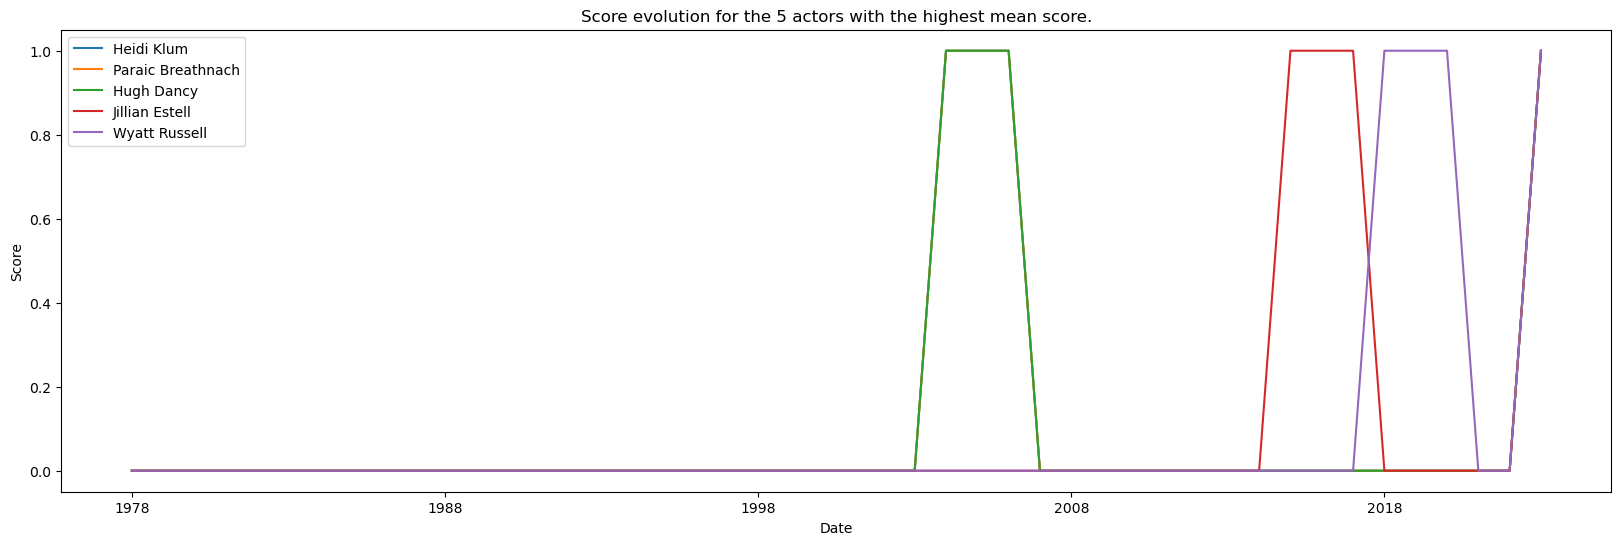

In [18]:
df_ratings_all_years.sort_values(by='mean_score', ascending=True).head().rename_axis(None).T.plot(figsize=(20,6))
plt.title("Score evolution for the 5 actors with the highest mean score.")
plt.xlabel('Date')
plt.ylabel('Score')
plt.show()

#### Looking at the actor with most scores

In [19]:
df_ratings_all_years['is_na']=df_ratings_all_years.apply(lambda row: row.isna().sum().sum(), axis=1)
print("Actors that have the least \"empty years\" throughout the 42 years of the dataset.")
df_ratings_all_years.sort_values(by='is_na', ascending=False).head(3)

Actors that have the least "empty years" throughout the 42 years of the dataset.


,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,...,2015,2016,2017,2018,2019,2020,2021,2022,mean_score,is_na
actor_name,,,,,,,,,,,,,,,,,,,,,
Jane Fonda,175.0,341.0,440.0,364.0,198.0,99.0,0.0,0.0,63.0,63.0,...,16.0,16.0,0.0,59.0,59.0,59.0,0.0,0.0,109.3125,0
Alexis Knapp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,89.0,89.0,161.0,72.0,72.0,0.0,0.0,0.0,80.2500,0
Maude Apatow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.0000,0


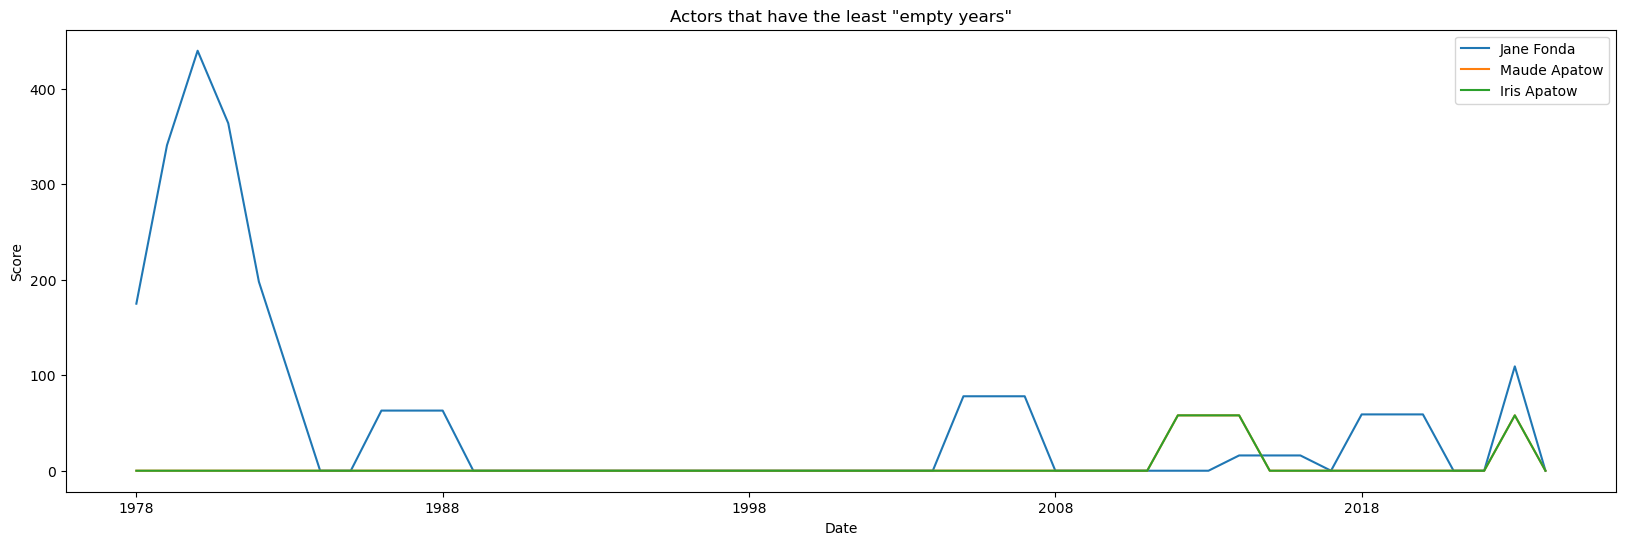

In [20]:
df_ratings_all_years.sort_values(by='is_na', ascending=True).head(3).rename_axis(None).T.plot(figsize=(20,6))
plt.title("Actors that have the least \"empty years\"")
plt.xlabel('Date')
plt.ylabel('Score')
plt.show()

In [21]:
df_ratings_all_years

,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,...,2015,2016,2017,2018,2019,2020,2021,2022,mean_score,is_na
actor_name,,,,,,,,,,,,,,,,,,,,,
Jane Fonda,175.0,341.0,440.0,364.0,198.0,99.0,0.0,0.0,63.0,63.0,...,16.0,16.0,0.0,59.0,59.0,59.0,0.0,0.0,109.312500,0
Clint Eastwood,97.0,186.0,360.0,263.0,260.0,180.0,347.0,343.0,332.0,165.0,...,0.0,0.0,0.0,71.0,71.0,71.0,36.0,36.0,132.052632,0
John Belushi,99.0,177.0,269.0,295.0,217.0,125.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226.500000,0
Burt Reynolds,178.0,262.0,262.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,114.500000,0
Goldie Hawn,88.0,88.0,258.0,170.0,251.0,81.0,147.0,66.0,132.0,125.0,...,0.0,0.0,43.0,43.0,43.0,0.0,0.0,0.0,104.814815,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Myha’la Herrold,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0,48.000000,0
Chase Sui Wonders,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0,48.000000,0
Rachel Sennott,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0,48.000000,0


# Output clean CSV

In [22]:
OUTPUT_FILE_NUMBERS = 'the_numbers_cleaned.tsv'
OUTPUT_PATH = os.path.join(DATA_PATH, OUTPUT_FILE_NUMBERS)
df_ratings_all_years.to_csv(OUTPUT_PATH, sep="\t")